# Mateusz Kuchta nr 116111
## Model XGBoost dla predykcji zajścia zdarzenia default
###### 04.08.2023

### Rozpoczęto od instalacji niezbędnych pakietów

In [1]:
# !pip install xgboost
# !pip install category_encoders

### Kolejnym krokiem jest import zastosowanych bibliotek

In [2]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#import math

### Wczytano zbiór danych
#### Do budowy modelu zastosowano zbiór wykorzystywany podczas zajęć z przedmiotu "Credit scoring - automatyzacja procesu biznesowego" prowadzonego w Szkole Głównej Handlowej w Warszawie, prowadzonego przez Pana dr Karola Przanowskiego, dzięki którego uprzejmości dataset może zostać użyty w pracy.
#### Zbiór zawiera 219 zmiennych, zarówno ciągłych, jak i kategorycznych. Umieszczono w nim 68499 obserwacji, gdzie każda z nich dotyczy innej aplikacji o produkt gotówkowy (product = 'css') lub ratalny (product = 'ins')

In [3]:
source_data = pd.read_sas('abt_app.sas7bdat', encoding = 'LATIN2')
data = source_data.copy()
print("Zaimportowany zbiór danych wraz z jego rozmiarem:")
data

Zaimportowany zbiór danych wraz z jego rozmiarem:


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default3,default6,default9,default12,default_cross3,default_cross6,default_cross9,default_cross12,cross_app_loan_amount,cross_app_n_installments
0,0000000001,css1970020500001,css,197002,59.0,0.492428,2.442599,2047.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000060,css1970020700004,css,197002,52.0,0.447902,1.023541,4885.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000013,css1970021100003,css,197002,38.0,0.586847,8.431703,593.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000089,css1970022400005,css,197002,37.0,0.165007,2.370792,2109.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000005,css1970022600002,css,197002,46.0,0.529964,1.805054,2770.0,5000.0,24.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5000.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68494,0000024575,ins1988123100021,ins,198812,37.0,0.229305,2.890728,2416.0,6984.0,36.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
68495,0000024576,ins1988123100031,ins,198812,46.0,0.336398,1.959978,1849.0,3624.0,12.0,...,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
68496,0000001517,ins1988123100032,ins,198812,76.0,1.061798,6.674157,356.0,2376.0,12.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68497,0000024577,ins1988123100041,ins,198812,55.0,0.636503,3.957055,652.0,2580.0,12.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Zdefiniowano globalne parametry
#### Jako zmienną celu wybrano 'default12' - binarny wskaźnik zajścia zdarzenia, w którym klient w trakcie pierwszych 12 miesięcy od otrzymania kredytu spóźnił się ze spłatą rat sumarycznie o co najmniej 90 dni

In [4]:
target_variable = 'default12'

#### Zdefiniowano benchmarki, które powinny być przestrzegane przez finalnie wybrany model. Zmienna 'gini_benchmark' wskazuje minimalny współczynnik Gini'ego dla modelu, zarówno dla zbioru testowego, jak i treningowego, natomiast zmienna 'gini_diff_benchmark' określa maksymalną różnicę pomiędzy współczynnikami Gini'ego w zbiorze treningowym, a Gini'm na zbiorze testowym, dla jednego modelu

In [76]:
gini_benchmark = 0.8
gini_diff_benchmark = 0.04

### Przetwarzanie zbioru danych
#### Zdecydowano się na ograniczenie zakresu modelu do jednego produktu - kredytu gotówkowego. Spowodowane jest to różną charakterystyką danych znanych w momencie aplikacji o tzw. "gotówkę" w odniesieniu do pożyczki ratalnej. Operacja ta obniżyła liczbę obserwacji do 34188.

In [5]:
data_css = data.loc[data['product'] == 'css'].copy()
print("Rozmiar zbioru danych dla produktu 'css':", data_css.shape)

Rozmiar zbioru danych dla produktu 'css': (34188, 219)


#### Po analizie rozkładu wartości binarnej zmiennej celu stwierdzono, w zbiorze znajduje się dostatecznie dużo "default'ów" (w literaturze można znaleźć informację, że do budowy poprawnego modelu scoring'owego wymagane jest posiadanie w analizowanym zbiorze co najmniej 300 dłużników).

In [6]:
print("Rozkład wartości zmiennej celu w zbiorze danych dla produktu 'css':")
data_css[target_variable].value_counts()

Rozkład wartości zmiennej celu w zbiorze danych dla produktu 'css':


1.0    19986
0.0     9791
Name: default12, dtype: int64

#### Ze zbioru pozbyto się obserwacji, w których odnotowano braki danych. Jest ich dużo, jeśli chodzi o wartość bezwzględną, jednakże uwzględniając rozmiar całego zestawu danych, nie uwzględnianie tych informacji nie powinno zaszkodzić modelowi. Dodatkowo, posortowano dane względem zmiennej 'aid'.

In [7]:
data_css.dropna(subset = [target_variable], inplace = True)
data_css.sort_values(by = ['aid'], inplace = True)
print("Rozmiar zbioru danych dla produktu 'css', po wyeliminowaniu obserwacji z brakami danych w tej zmiennej:", 
      data_css.shape)

Rozmiar zbioru danych dla produktu 'css', po wyeliminowaniu obserwacji z brakami danych w tej zmiennej: (29777, 219)


### Przetwarzanie zmiennych
#### Znając logikę nazewnictwa zmiennych w zbiorze, utworzono listę nazw zmiennych dla przedrostków 'app', 'act', 'agr' oraz 'ags'

In [8]:
variables = [variable for variable in list(data_css) 
             if any(variable.casefold().startswith(prefix) for prefix in ['app', 'act', 'agr', 'ags'])]
print('Liczba zmiennych spełniających warunek określonego przedrostka =', len(variables))

Liczba zmiennych spełniających warunek określonego przedrostka = 201


#### Konieczne jest rozdzielenie zmiennych ze względu na ich zawartość - na zmienne jakościowe(char) oraz ilościowe(num)

In [9]:
variables_char_list = list(data_css[variables].select_dtypes(include = 'object'))
variables_num_list = list(data_css[variables].select_dtypes(include = 'number'))
print('Liczba zmiennych jakościowych =', len(variables_char_list))
print('Liczba zmiennych ilościowych =', len(variables_num_list))

Liczba zmiennych jakościowych = 7
Liczba zmiennych ilościowych = 194


#### Model XGBoost nie jest w stanie operować na zmiennych jakościowych, co wymusza konieczność zastosowania kodowania\kategoryzacji tychże zmiennych. W tym celu skorzystano z pakietu category_encoders mającego możliwość kodowania binarnego. 7 zmiennych jakościowych zostało poddane temu procesowi, na skutek czego powstało 16 nowych zmiennych binarnych.

In [10]:
encoding = ce.BinaryEncoder(cols = variables_char_list)
data_encoded = encoding.fit_transform(data_css[variables_char_list])
variables_char_encoded_list = list(data_encoded)
print("Lista", len(variables_char_encoded_list),"zbinowanych zmiennych jakościowych:")
variables_char_encoded_list

Lista 16 zbinowanych zmiennych jakościowych:


['app_char_branch_0',
 'app_char_gender_0',
 'app_char_gender_1',
 'app_char_job_code_0',
 'app_char_job_code_1',
 'app_char_job_code_2',
 'app_char_marital_status_0',
 'app_char_marital_status_1',
 'app_char_marital_status_2',
 'app_char_city_0',
 'app_char_city_1',
 'app_char_city_2',
 'app_char_home_status_0',
 'app_char_home_status_1',
 'app_char_cars_0',
 'app_char_cars_1']

#### Nowo powstałe zmienne dołączono do zbioru pełnego dla produktu 'css', tworząc nowy zbiór 'data_full'

In [11]:
data_full = pd.concat([data_css, data_encoded], axis = 1, join = 'inner')
print("Nowy zbiór danych, powstały z połączenia zbioru oryginalnego dla produktu gotówkowego")
print("oraz zbioru składającego się z nowo utworzonych zmiennych binarnych:")
data_full

Nowy zbiór danych, powstały z połączenia zbioru oryginalnego dla produktu gotówkowego
oraz zbioru składającego się z nowo utworzonych zmiennych binarnych:


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,app_char_marital_status_0,app_char_marital_status_1,app_char_marital_status_2,app_char_city_0,app_char_city_1,app_char_city_2,app_char_home_status_0,app_char_home_status_1,app_char_cars_0,app_char_cars_1
0,0000000001,css1970020500001,css,197002,59.0,0.492428,2.442599,2047.0,5000.0,24.0,...,0,0,1,0,0,1,0,1,0,1
1,0000000060,css1970020700004,css,197002,52.0,0.447902,1.023541,4885.0,5000.0,24.0,...,0,0,1,0,1,0,1,0,0,1
2,0000000013,css1970021100003,css,197002,38.0,0.586847,8.431703,593.0,5000.0,24.0,...,0,0,1,0,1,1,0,1,0,1
3,0000000089,css1970022400005,css,197002,37.0,0.165007,2.370792,2109.0,5000.0,24.0,...,0,0,1,0,1,0,0,1,0,1
4,0000000005,css1970022600002,css,197002,46.0,0.529964,1.805054,2770.0,5000.0,24.0,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34183,0000009715,css1988122500162,css,198812,86.0,0.234753,2.876870,1738.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,1,0
34184,0000017452,css1988122500175,css,198812,72.0,0.729145,5.149331,971.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,0,1
34185,0000000040,css1988122600002,css,198812,84.0,0.405874,3.337784,1498.0,5000.0,24.0,...,0,1,0,0,0,1,0,1,1,0
34186,0000000081,css1988122600006,css,198812,93.0,0.624339,4.409171,1134.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,0,1


#### Utworzono dwie listy zmiennych - pierwsza, zawierająca jedynie zmienne numeryczne oraz zmienne jakościowe binowane; druga, składająca się dodatkowo ze zmiennej celu, zmiennej czasowej oraz identyfikatora

In [12]:
variables_full_wo_target = variables_num_list + variables_char_encoded_list
variables_full = variables_num_list + variables_char_encoded_list + [target_variable] + ['period'] + ['aid']
print("Liczba zmiennych używanych do budowy modelu:", len(variables_full))

Liczba zmiennych używanych do budowy modelu: 213


### Budowa modelu XGBoost

#### Budowę modelu rozpoczęto od podziału przygotowanego zestawu danych na zbiór testowy oraz treningowy w proporcjach 30/70

In [13]:
train, test = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train.shape)
print("Rozmiar zbioru testowego:", test.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Wprowadzono zmienne X oraz Y dla zbioru testowego i treningowego, gdzie Y zawiera zmienną objaśnianą, natomiast X składa się ze zmiennych objaśniających

In [14]:
X_train = train[variables_full_wo_target]
Y_train = train[target_variable]
X_test = test[variables_full_wo_target]
Y_test = test[target_variable]

#### Model XGBoost wymaga ściśle określonej struktury danych. Aby to uzyskać, wykorzystano funkcję z pakietu xgboost o nazwie 'xgboost.DMatrix'

In [15]:
xdm_train = xgb.DMatrix(X_train, Y_train, missing = True)
xdm_test  = xgb.DMatrix(X_test, Y_test, missing = True)

#### Kolejnym etapem było wytrenowanie modelu na zbiorze treningowym, a następnie jego walidacja na zbiorze testowym. Przeprowadzono szereg treningów i walidacji celem znalezienia najlepszego modelu, w tym celu manipulując parametrami uczenia.
#### W następnym kroku użyto nauczonego modelu do utworzenia nowych zmiennych, w których przechowywano klasyfikację wykonaną przez XGBoost
#### Finalnie podsumowano obliczeniem mocy predykcyjnej modelu dla zbioru testowego i treningowego wyliczając współczynnik GINI przy pomocy funkcji roc_auc_score z biblioteki sklearn

#### Pierwszy zbudowany model, stanowił element poglądowy do dalszej analizy. Jego głównym celem, było zbudowanie prostego modelu XGBoost na przygotowanych danych, celem zgrubnego oszacowania istotności zmiennych przy pomocy statystyki F-score

GINI TRAIN =  89.71%
GINI TEST =  80.04%
GINI DIFF =  9.67%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

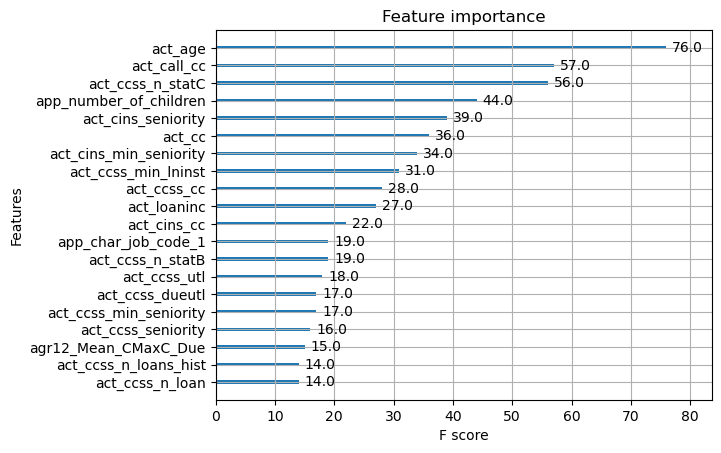

In [74]:
            M_premodel = xgb.train(  
                            {   
                                'max_depth' : 6, 
                                'seed' : 1998, 
                                'objective' : 'binary:logitraw',
                                'learning_rate' : 0.3,
                                'min_split_loss' : 0, 
                                'eval_metric' : 'auc'
                            },
                            xdm_train, 
                            num_boost_round = 20, 
                            evals = [
                                        (xdm_test, 'eval'), 
                                        (xdm_train, 'train')
                                    ],
                            verbose_eval = 0
                        )

            Y_M_train_premodel = M_premodel.predict(xdm_train)
            Y_M_test_premodel = M_premodel.predict(xdm_test)

            GINI_train_premodel = 2 * roc_auc_score(Y_train, Y_M_train_premodel) - 1
            GINI_test_premodel  = 2 * roc_auc_score(Y_test, Y_M_test_premodel) - 1

print('GINI TRAIN = ', '{:.2%}'.format(GINI_train_premodel))
print('GINI TEST = ', '{:.2%}'.format(GINI_test_premodel))
print('GINI DIFF = ', '{:.2%}'.format(GINI_train_premodel - GINI_test_premodel))
xgb.plot_importance(M_premodel, max_num_features = 20)

#### Po przeanalizowaniu ważności zmiennych, dokonano iteracyjnego, wielokrotnego trenowania modeli z różnymi parametrami dostępnymi w pakiecie xgboost. Następnie przeprowadzono analizę współczynników Giniego dla zbioru testowego oraz treningowego, a także określono różnicę między tymi wartościami dla poszczególnych modeli. 

In [62]:
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame( 
                    {
                        'GINI_train' : [],
                        'GINI_test' : [],
                        'max_depth' : [],
                        'learning_rate' : [],
                        'min_split_loss' : [],
                        'GINI_diff' : []
                    }
                 )

for i in range(3):
    for j in range(5):
        for k in range(5):
            M = xgb.train(  
                            {   
                                'max_depth' : i+3, 
                                'seed' : 1998, 
                                'objective' : 'binary:logitraw',
                                'learning_rate' : 0.1 * (j + 5),
                                'min_split_loss' : k + 3, 
                                'eval_metric' : 'auc'
                            },
                            xdm_train, 
                            num_boost_round = 1000, 
                            evals = [
                                        (xdm_test, 'eval'), 
                                        (xdm_train, 'train')
                                    ],
                            verbose_eval = 0
                        )

            Y_M_train = M.predict(xdm_train)
            Y_M_test = M.predict(xdm_test)

            GINI_train = 2 * roc_auc_score(Y_train, Y_M_train) - 1
            GINI_test  = 2 * roc_auc_score(Y_test, Y_M_test) - 1

            df.loc[len(df)] =   {
                                    'GINI_train': GINI_train, 
                                    'GINI_test': GINI_test, 
                                    'max_depth': i + 3, 
                                    'learning_rate': 0.1 * (j + 5),
                                    'min_split_loss' : k + 3,
                                    'GINI_diff': abs(GINI_train - GINI_test)
                                }
df

#### Najlepszy model wybrano dobierając odpowiednie benchmarki

In [89]:
df_filtered = df.loc[(df['GINI_train'] > gini_benchmark) & 
                     (df['GINI_test'] > gini_benchmark) & 
                     (df['GINI_diff'] < 0.5)].copy()
df_filtered.sort_values(by = ['GINI_diff'], inplace = True)
df_filtered

,GINI_train,GINI_test,max_depth,learning_rate,min_split_loss,GINI_diff
4,0.852832,0.812864,3,0.5,7,0.039968
9,0.848061,0.807034,3,0.6,7,0.041028
3,0.865132,0.812724,3,0.5,6,0.052408
8,0.864424,0.810137,3,0.6,6,0.054287
7,0.864117,0.809094,3,0.6,5,0.055024
2,0.870871,0.810646,3,0.5,5,0.060225
18,0.867702,0.802915,3,0.8,6,0.064786
19,0.870115,0.803443,3,0.8,7,0.066671
14,0.872645,0.802576,3,0.7,7,0.070070
6,0.877691,0.807421,3,0.6,4,0.070269


#### Po wybraniu optymalnych parametrów modelu, zapisano go pod zmienną M_chosen_model

In [64]:
            M_chosen_model = xgb.train(  
                            {   
                                'max_depth' : 3, 
                                'seed' : 1998, 
                                'objective' : 'binary:logitraw',
                                'learning_rate' : 0.5,
                                'min_split_loss' : 7, 
                                'eval_metric' : 'auc'
                            },
                            xdm_train, 
                            num_boost_round = 1000, 
                            evals = [
                                        (xdm_test, 'eval'), 
                                        (xdm_train, 'train')
                                    ],
                            verbose_eval = 0
                        )

            Y_M_train_chosen_model = M_chosen_model.predict(xdm_train)
            Y_M_test_chosen_model = M_chosen_model.predict(xdm_test)

            GINI_train_chosen_model = 2 * roc_auc_score(Y_train, Y_M_train_chosen_model) - 1
            GINI_test_chosen_model  = 2 * roc_auc_score(Y_test, Y_M_test_chosen_model) - 1

#Predictive power calculation
print('GINI TRAIN = ', '{:.2%}'.format(GINI_train_chosen_model))
print('GINI TEST = ', '{:.2%}'.format(GINI_test_chosen_model))
print('GINI DIFF = ', '{:.2%}'.format(GINI_train_chosen_model - GINI_test_chosen_model))

GINI TRAIN =  85.28%
GINI TEST =  81.29%
GINI DIFF =  4.00%


### Wizualizacje
#### Zwizualizowano skuteczność modelu, przy pomocy krzywych ROC, zarówno dla zbiory treningowego, jak i testowego, celem porównania ich kształtu i wizualnej oceny stabilności klasyfikacji w zależności od znajomości danych

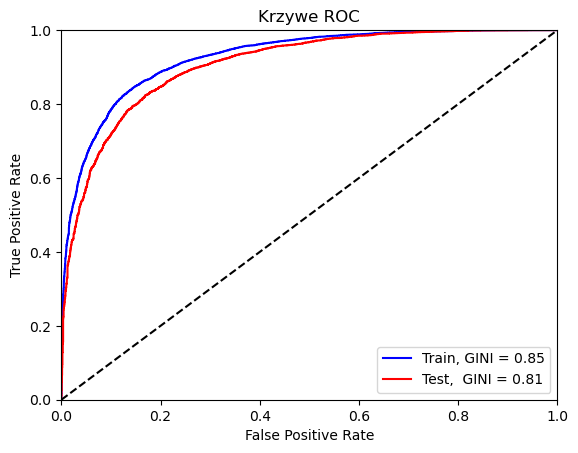

In [83]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train.values.ravel(), Y_M_train_chosen_model)
fpr_test,  tpr_test,  thresholds_test  = roc_curve(Y_test.values.ravel(), Y_M_test_chosen_model)
plt.plot(fpr_train, tpr_train, 'blue', label = 'Train, GINI = '+'{:4.2f}'.format(GINI_train_chosen_model))
plt.plot(fpr_test, tpr_test, 'red', label = 'Test,  GINI = '+'{:4.2f}'.format(GINI_test_chosen_model))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Krzywe ROC')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

#### Dodatkowo, ponownie zweryfikowano ważność poszczególnych zmiennych, tym razem w finalnym modelu, celem porównania z modelem wstępnym

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

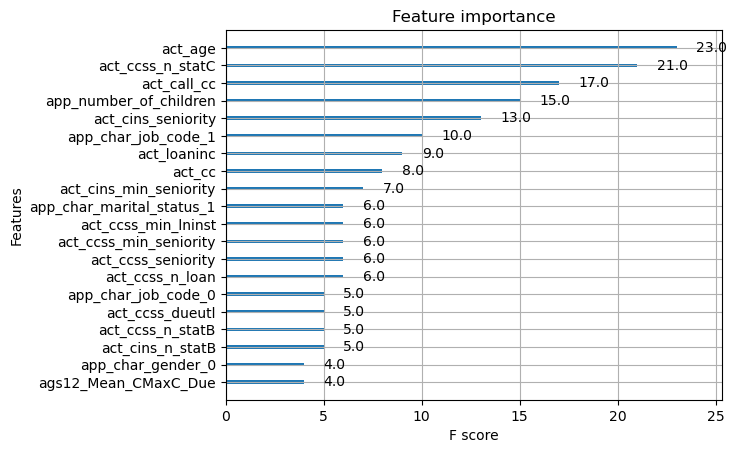

In [84]:
xgb.plot_importance(M_chosen_model, max_num_features = 20)

### Postprocessing
#### Zapisano model do zewnętrznego pliku

In [86]:
M_chosen_model.save_model('XGBoostModel_MK116111_1.model')

In [ ]:
#Reading the model
#model2 = xgboost.Booster() 
#model2.load_model('xgb1.model')
#Y_pred_test2 = model2.predict(xdm_test)